<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/shuby-dev/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [5]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms.functional as TF
import torchvision.models as models
import pandas as pd

%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')
# print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


## Loading Data

In [6]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
    validation_size = training_data.shape[0]//10
    validation_data = training_data[0:validation_size]
    training_data = training_data[validation_size:]
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
    validation_size = training_labels.shape[0]//10
    validation_labels = training_labels[0:validation_size]
    training_labels = training_labels[validation_size:]
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)

## Preprocessing

### Preprocessing Helper Functions

In [7]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1, l2 = int(label[0]), mapping[label[1].int()]
    readables.append((l1,l2,))
  return readables

In [8]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])    
    # plt.colorbar()
    plt.show()

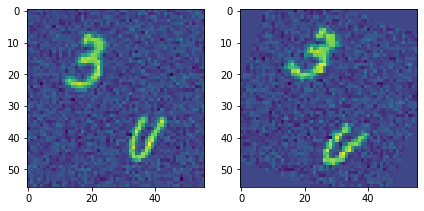

In [9]:
def generate_rotation(image_tensor, rotate_angles=[-20,20]):
    outputs = []
    for angle in rotate_angles:
      outputs.append(TF.rotate(image_tensor, angle))
    return outputs

sample_tensor = torch.from_numpy(training_data[0,None]).float()
rotated_tensor = generate_rotation(sample_tensor)[0]
img_grid(1,2,[sample_tensor[0],rotated_tensor[0]])

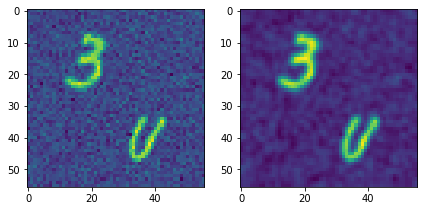

In [10]:
def generate_blur(image_tensor, blur_kernal = [1]):
  outputs = []
  for k in blur_kernal:
    outputs.append(TF.gaussian_blur(image_tensor, [k,k]))
  return outputs

sample_tensor = torch.from_numpy(training_data[0,None]).float()
sharp_tensor = generate_blur(sample_tensor,[3])[0]
img_grid(1,2,[sample_tensor[0],sharp_tensor[0]])

In [11]:
# transform all data to the output format
def process_training_data(data, labels, rotate_angles = [-30,-15,15,30], blur_kernal = [3]):
  multiplier = (1+len(rotate_angles)+len(blur_kernal))
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,0:10]))
    letter_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,10:]))
    # Creating the rotation and sharpness images
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_rotation(norm_img, rotate_angles):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_blur(norm_img, blur_kernal):
      new_data[output_index] = s_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset
  

In [12]:
def process_testing_data(data):
  data_tensor = torch.from_numpy(data[:,None]).float()
  dataset = torch.empty((len(data),1,56,56))
  for i in tqdm(range(len(data_tensor))):
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    dataset[i] = norm_img
  return dataset
testing_dataset = process_testing_data(testing_data)

100%|██████████| 15000/15000 [00:01<00:00, 7759.23it/s]


### Processing The Data

Process the data and put the data into dataloader

In [13]:
def make_data_loader(dataset, batch_size=30, shuffle=True, num_workers=2):
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  return dataloader

training_dataset = process_training_data(training_data, training_labels)
validation_dataset = process_training_data(validation_data,validation_labels, [], [])

training_loader = make_data_loader(training_dataset)
validation_loader = make_data_loader(validation_dataset)

100%|██████████| 3000/3000 [00:00<00:00, 5255.48it/s]


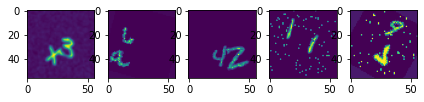

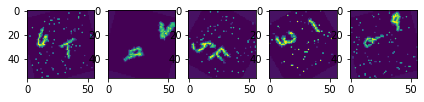

[(3, 'x'), (6, 'a'), (4, 'z'), (1, 'i'), (9, 'j'), (6, 't'), (9, 'v'), (5, 'f'), (1, 'w'), (9, 'o')]


In [14]:
def show_sample(n):
  perm = torch.randperm(len(training_dataset))
  idx = perm[:n]
  data, labels = training_dataset[idx]
  img_grid(n//5,5 , data[:,0])
  print(convert_labels_to_readables(labels))
show_sample(10)

## Training Model

### Multi-Output Model

Initalize the Multilabel Model

In [13]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
         # 4 convolution layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        
        self.pool2 = nn.MaxPool2d(2, 2)

        # 3 Dense Layer
        self.fc11 = nn.Linear(256*3*3, 1000)
        self.fc12 = nn.Linear(256*3*3, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(100, 10)
        self.fc32 = nn.Linear(1000, 26)

    def forward(self, x):
        # Convolution Layers
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        # print(x.size())
        # Dense Layers
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        l1 = F.relu(self.fc21(F.relu(self.fc11(x))))
        l2 = F.relu(self.fc22(F.relu(self.fc12(x))))
        l1 = self.fc31(l1)
        l2 = self.fc32(l2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Custom Res Net with Multi Output




In [56]:
class Bottleneck(nn.Module):
  def __init__(self, inplane, width, outplane, stride = 1):
    super(Bottleneck, self).__init__()
    self.inplane = inplane
    self.outplane = outplane
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(inplane, width, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(width)
    self.conv2 = nn.Conv2d(width, width, 3, padding=1, bias=False, stride=stride)
    self.bn2 = nn.BatchNorm2d(width)
    self.conv3 = nn.Conv2d(width, outplane, 1, bias=False)
    self.bn3 = nn.BatchNorm2d(outplane)
    self.conv4, self.bn4 = nn.Identity(), nn.Identity()
    if inplane != outplane or stride != 1: 
      self.conv4 = nn.Conv2d(inplane, outplane, 1, bias=False, stride=stride)
      self.bn4 = nn.BatchNorm2d(outplane)
  
  def forward(self, x):
        identity = self.bn4(self.conv4(x))

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

class CustomResNet(nn.Module):

    def __init__(self, groups = 1, width_per_group = 64):
        super(CustomResNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # 3 Bottleneck Layers
        self.layer1 = Bottleneck(64,64,64)
        self.layer2 = Bottleneck(64,64,128, 2)
        self.layer3 = Bottleneck(128,64,256, 2)
        self.layer4 = Bottleneck(256,64,256, 2)

        # self.layer4 = self._make_layer(models.resnet.BasicBlock, 512, 1, stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc1 = nn.Linear(9216, 10)
        self.fc2 = nn.Linear(9216, 26)        

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        l1 = self.fc1(x)
        l2 = self.fc2(x)
        return l1,l2


### Training and Validation

Initialize network validation and training function

In [16]:
def validate_model(model):
  digit_acc, letter_acc = 0, 0
  print("Starting Validation Iteration")
  for i, validation_data in enumerate(tqdm(validation_loader)):
    inputs, labels = validation_data
    o1, o2 = model(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float())
  digit_acc = digit_acc/len(validation_loader)
  letter_acc = letter_acc / len(validation_loader)
  print(f'\n Digit Accuracy: {digit_acc.item()}, Letter Accuracy: {letter_acc.item()}')
  return (digit_acc.item(), letter_acc.item())

In [17]:
def train_network(net, optimizer, criterion, max_epoch = 10, last_index = len(training_loader), do_validation = True):
  running_loss = 0.0
  digits_accs, letter_accs = [], []
  for epoch in range(max_epoch):  # loop over the dataset multiple times
      cnt = 0
      print("Starting Training Iteration")
      for i, data in enumerate(tqdm(training_loader)):
          if epoch == max_epoch - 1 and i > last_index:
            break
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          cnt+=1
          if i % 100 == 99:
            print('[%d] loss: %.3f' % (i // 100, running_loss / cnt))
            running_loss, cnt = 0.0, 0
      if do_validation:
        digit_acc, letter_acc = validate_model(net)
        digits_accs.append(digit_acc)
        letter_accs.append(letter_acc)
        return (digits_accs, letter_accs)

In [ ]:
def train_model(net, optimizer, do_validation = True, epoch = 1, last_index = len(training_loader)):
  multi_net_criterion = nn.CrossEntropyLoss()
  def ml_criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2
  if do_validation:
    res = train_network(net, optimizer, criterion=ml_criterion, max_epoch=epoch, last_index=last_index)
    digit_accuracies, letter_accuracies = res
  else: 
    res = train_network(net, optimizer, criterion=ml_criterion,  max_epoch=epoch, last_index=last_index, do_validation=do_validation)
  return net

lr, momentum, weight_decay = 0.001, 0.9, 1e-5
res_net = CustomResNet()
optimizer = optim.SGD(res_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
res_net = train_model(res_net, optimizer, epoch = 1)

Starting Training Iteration


  2%|▏         | 100/5400 [01:01<54:44,  1.61it/s]

[0] loss: 6.714


  4%|▎         | 200/5400 [02:03<53:44,  1.61it/s]

[1] loss: 5.912


  6%|▌         | 300/5400 [03:04<52:49,  1.61it/s]

[2] loss: 5.552


  7%|▋         | 400/5400 [04:05<50:19,  1.66it/s]

[3] loss: 5.233


  9%|▉         | 500/5400 [05:06<48:52,  1.67it/s]

[4] loss: 4.936


 11%|█         | 600/5400 [06:07<49:17,  1.62it/s]

[5] loss: 4.706


 12%|█▏        | 660/5400 [06:44<48:50,  1.62it/s]

In [45]:
lr, momentum, weight_decay = 0.00001, 0.9, 1e-5
optimizer = optim.SGD(res_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
res_net = train_model(res_net, optimizer, epoch = 1, last_index=len(training_loader)//6)

Starting Training Iteration


  2%|▏         | 100/5400 [01:17<1:08:14,  1.29it/s]

[0] loss: 0.765


  4%|▎         | 200/5400 [02:34<1:06:25,  1.30it/s]

[1] loss: 0.677


  6%|▌         | 300/5400 [03:51<1:05:22,  1.30it/s]

[2] loss: 0.619


  7%|▋         | 400/5400 [05:08<1:04:02,  1.30it/s]

[3] loss: 0.603


  9%|▉         | 500/5400 [06:26<1:03:19,  1.29it/s]

[4] loss: 0.625


 11%|█         | 600/5400 [07:44<1:02:08,  1.29it/s]

[5] loss: 0.628


 13%|█▎        | 700/5400 [09:01<1:00:44,  1.29it/s]

[6] loss: 0.604


 15%|█▍        | 800/5400 [10:18<59:21,  1.29it/s]

[7] loss: 0.578


 17%|█▋        | 900/5400 [11:34<57:29,  1.30it/s]

[8] loss: 0.586


 17%|█▋        | 901/5400 [11:35<57:52,  1.30it/s]


Starting Validation Iteration


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


 Digit Accuracy: 0.9410005211830139, Letter Accuracy: 0.8906670212745667


## Results

Quick Sanity check

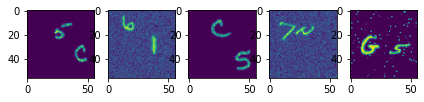

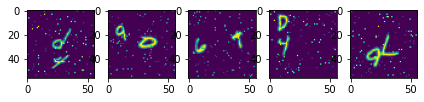

[(5, 'c'), (6, 'i'), (5, 'c'), (7, 'n'), (5, 'g'), (4, 'd'), (9, 'o'), (6, 't'), (4, 'y'), (9, 'l')]


In [46]:
img_grid(2, 5, testing_dataset[10000:10010,0])
l1, l2 = res_net(testing_dataset[10000:10010])
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
print(list(zip(l1,map(lambda x: mapping[x], l2))))

In [1]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  l1,l2 = res_net(testing_dataset[k:k+100])
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

NameError: ignored

In [34]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)

        # Id                              Category
0          0  100000000000000000000000000001000000
1          1  000010000000000000000100000000000000
2          2  000000000100000000010000000000000000
3          3  100000000000000000000100000000000000
4          4  000000100000000000010000000000000000
...      ...                                   ...
14995  14995  000100000000001000000000000000000000
14996  14996  000100000010000000000000000000000000
14997  14997  000000100000000000000000001000000000
14998  14998  010000000000000000100000000000000000
14999  14999  001000000000000000001000000000000000

[15000 rows x 2 columns]
